In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier

from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from sklearn.datasets import make_classification

In [8]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis - train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [12]:
gp_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/GP/GP_matern_kernel/'
nek_list = ["2", "3", "5", "9"]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
feat_types = ['moe', 'mfp']
samplings = ['scaled', 'UNDER' , 'SMOTE', 'ADASYN']
k=7

In [19]:
def err_vs_var(df,title, figure_path=None, filename=None):
    df['error']= df['actual']-df['prediction'] 
    true_labels = df['actual'] 
    
    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    df['prediction variance'] = np.nan
    

    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    ad_dist = df['ADdist']

    data = {
        'prediction variance': df['prediction variance'],
        'Prediction Type': df['prediction_type'],
        'feat_type': df['feat_type'],
        'ADdist' : df['ADdist'], 
        'strategy': df['strategy'], 
        'error': df['error']
    
    }
    plot_df = pd.DataFrame(data)
    g = sns.scatterplot(plot_df, x='prediction variance', y='error', hue='Prediction Type')

    
    # handles, labels = axs[1, 1].get_legend_handles_labels()

    # fig.legend(handles, labels, bbox_to_anchor = [0.54, 0], fontsize=18 )
    plt.tight_layout() 
  
    plt.suptitle(title, fontsize=20,y=1.03)
    if figure_path is not None: 
        plt.savefig(f'{figure_path}{filename}.png',bbox_inches='tight')

    plt.show(); 
    

NEK2 binding


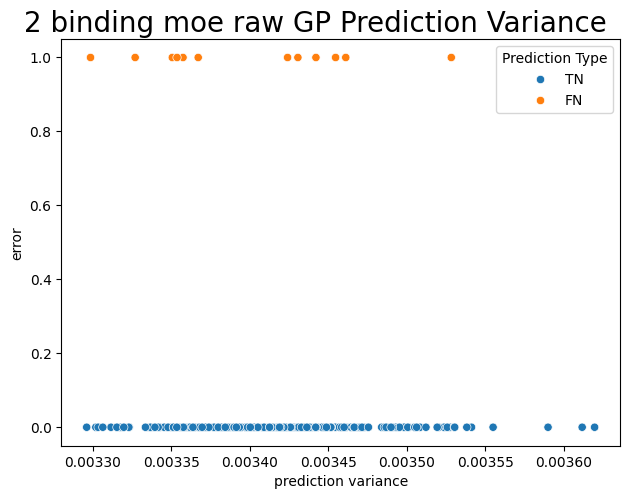

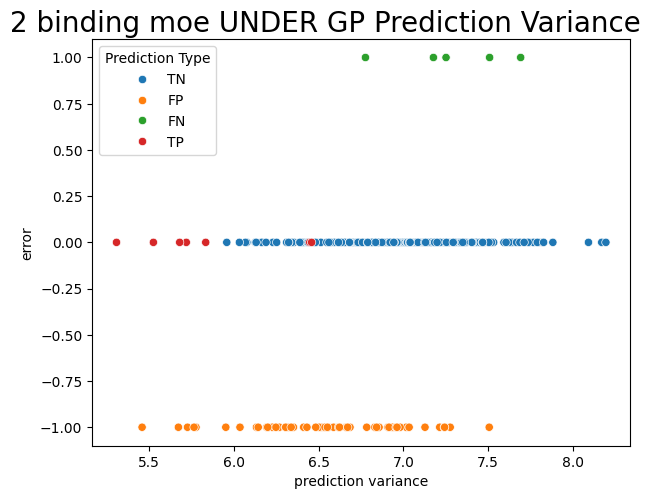

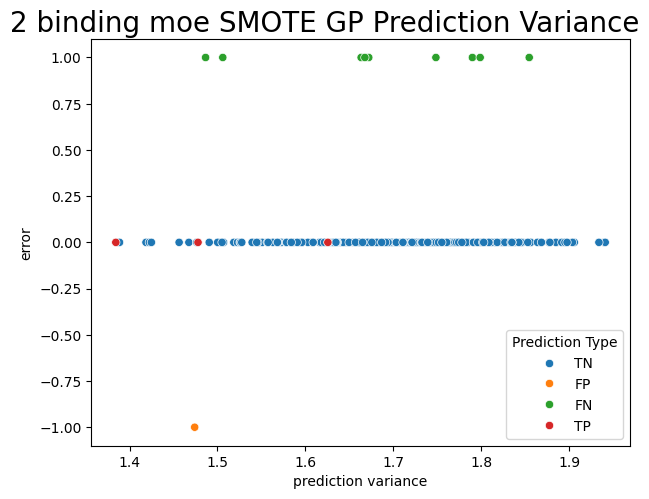

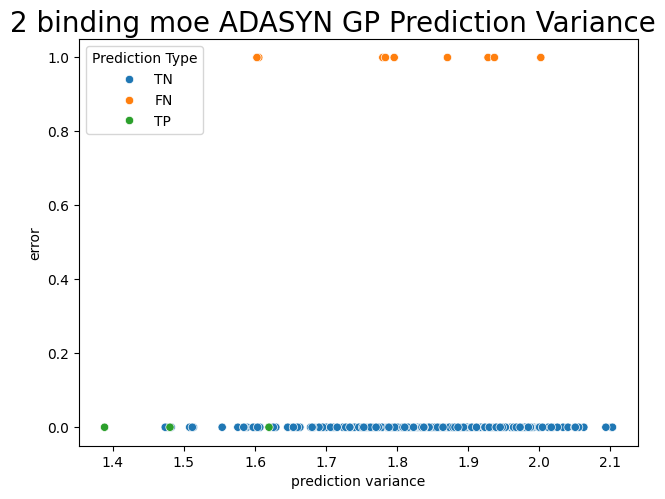

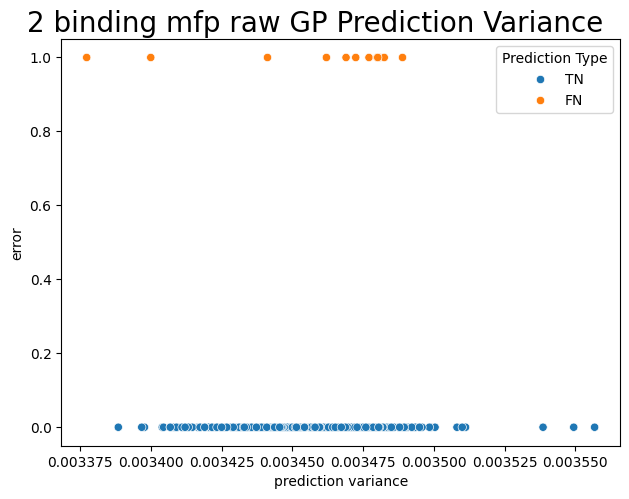

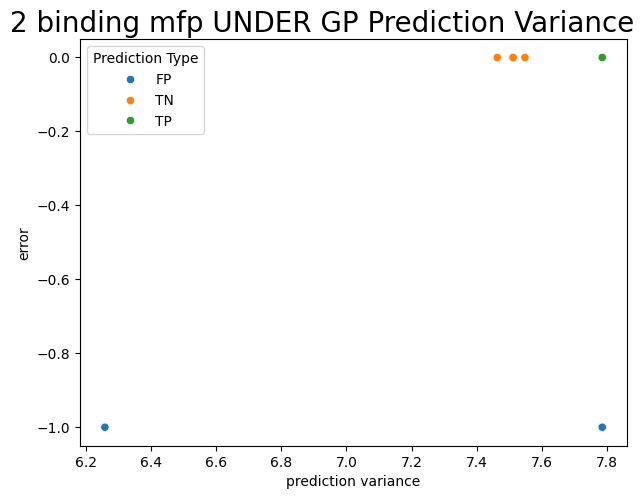

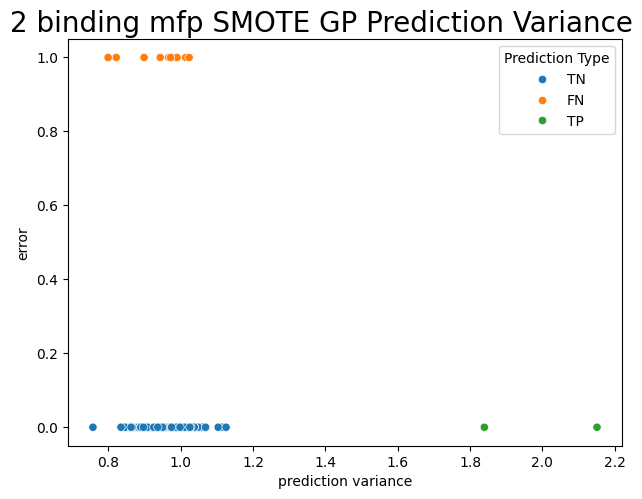

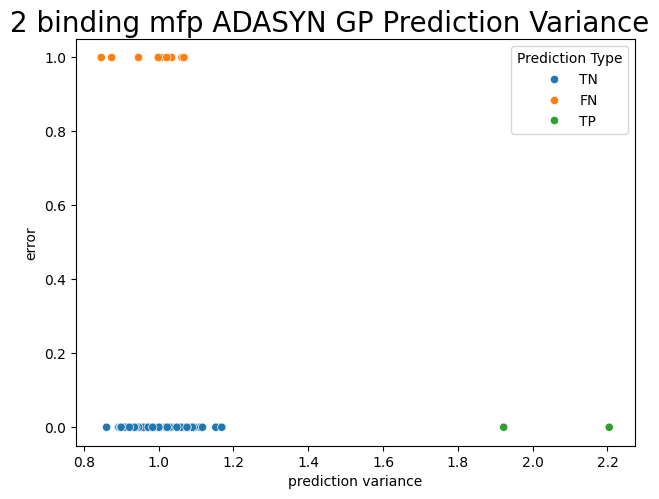

NEK2 inhibition


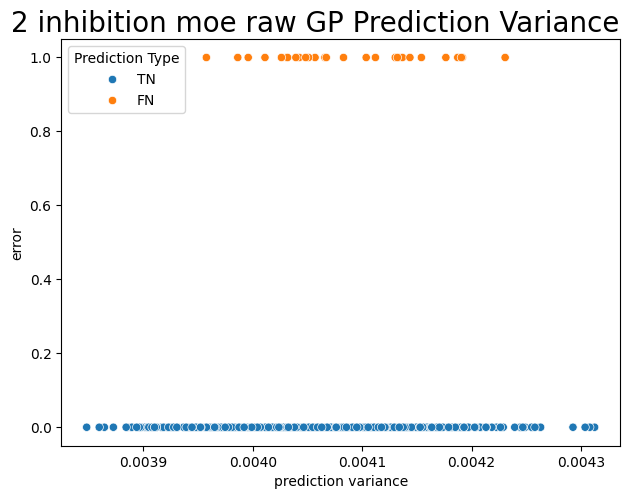

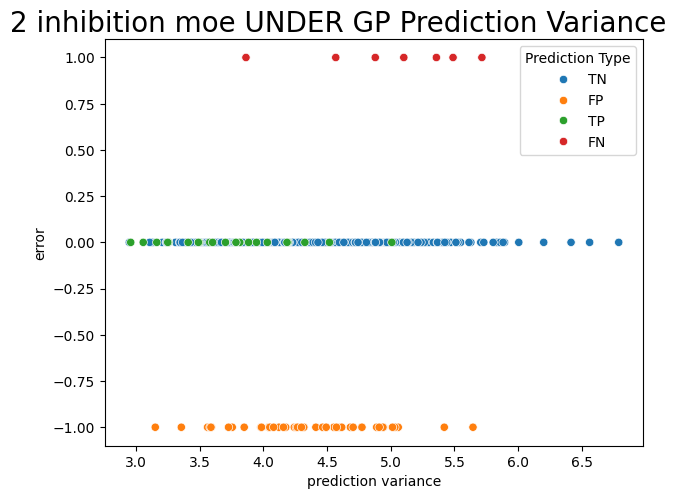

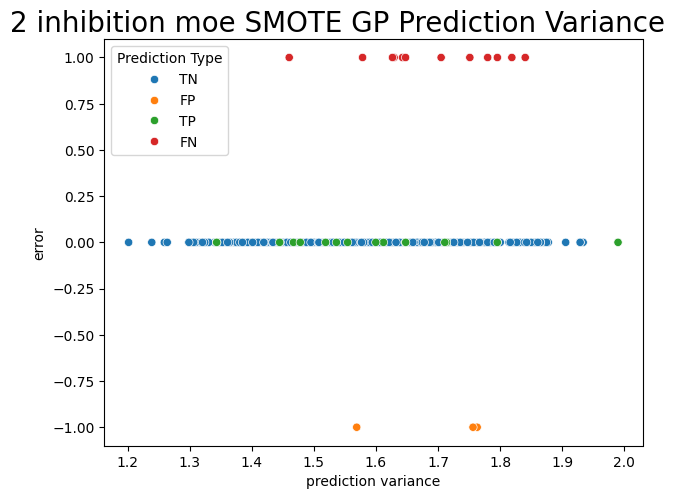

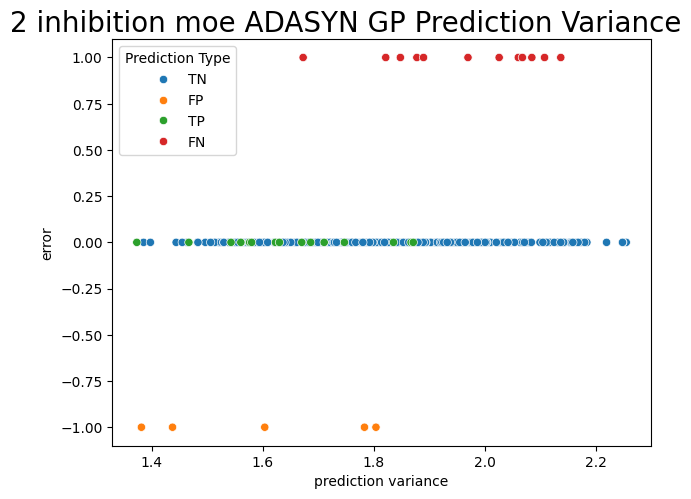

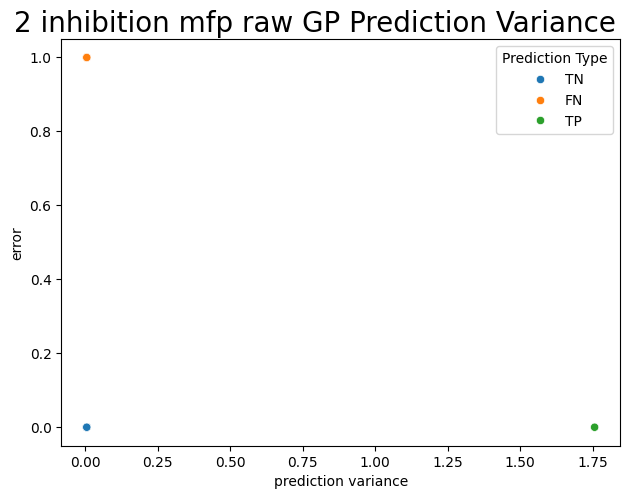

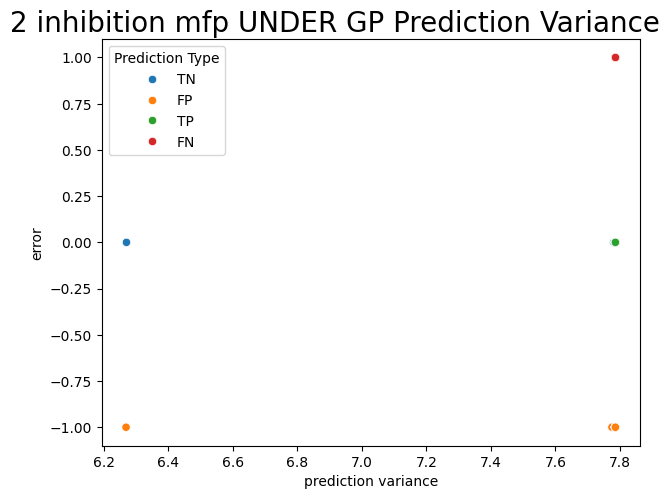

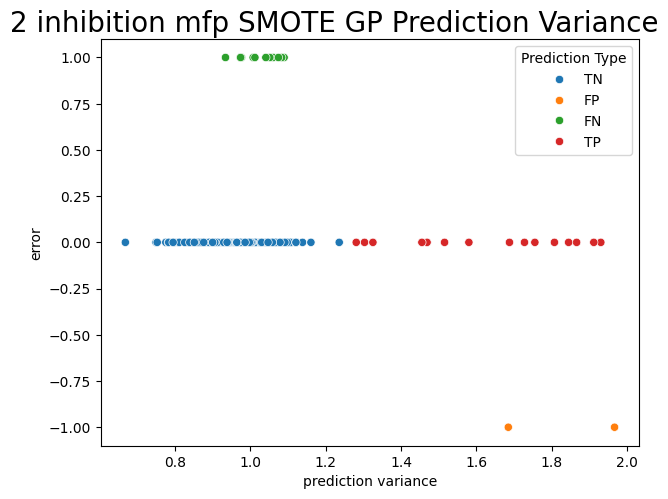

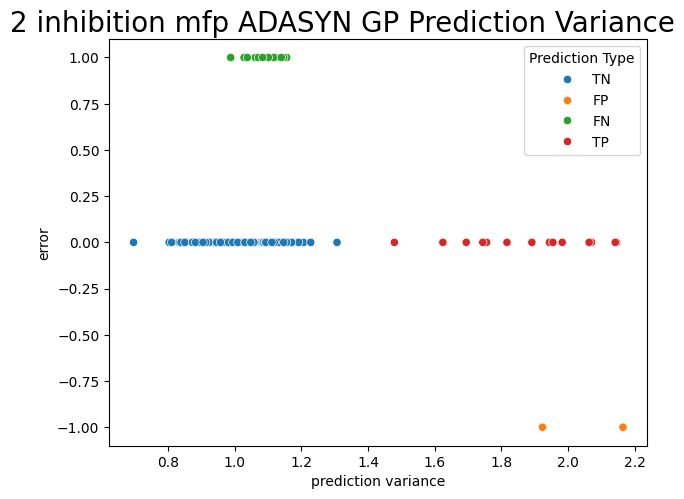

NEK3 binding


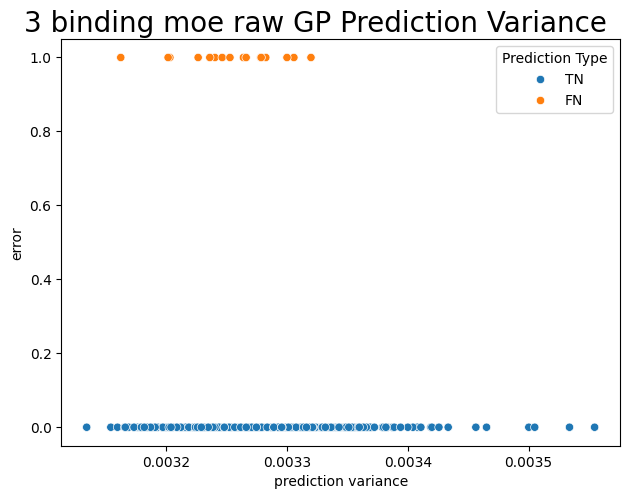

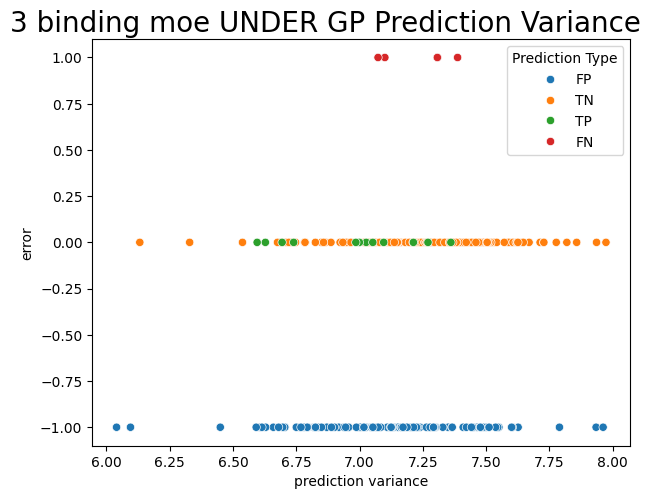

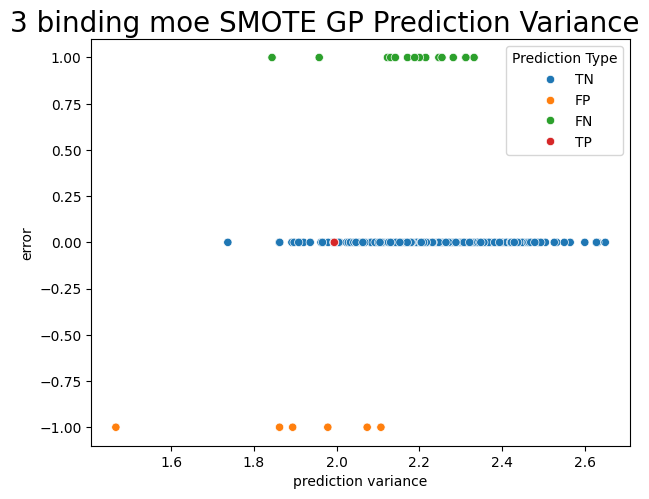

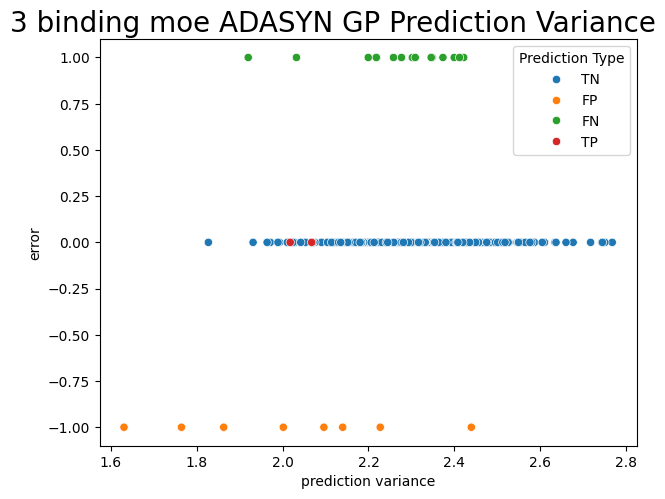

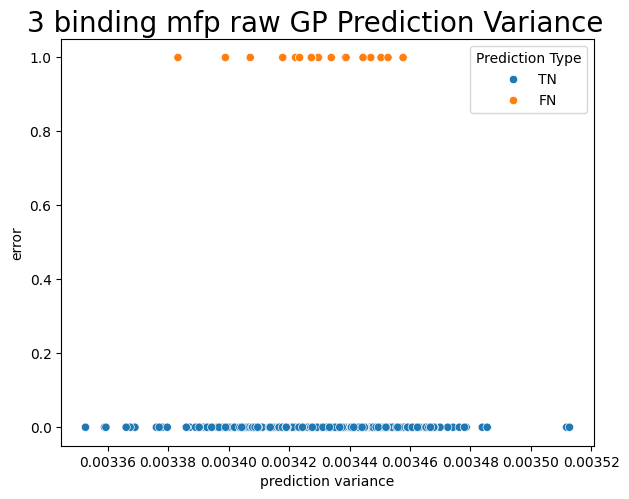

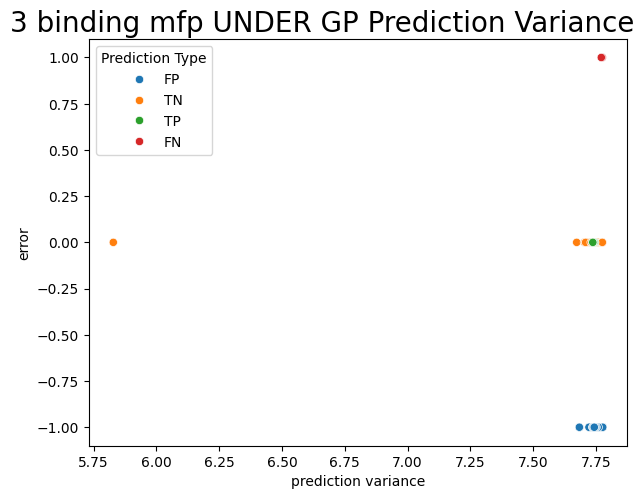

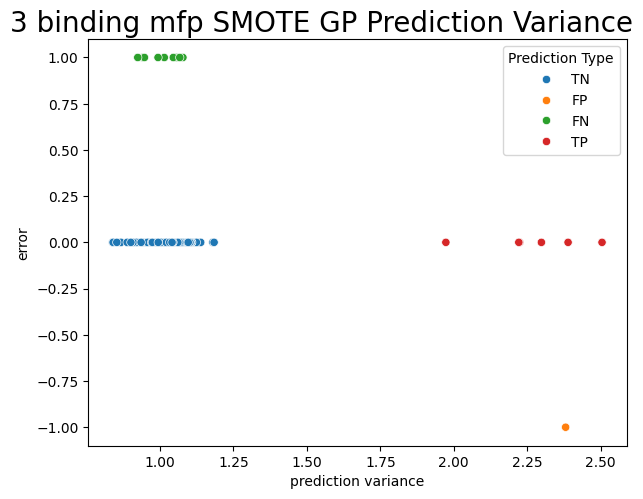

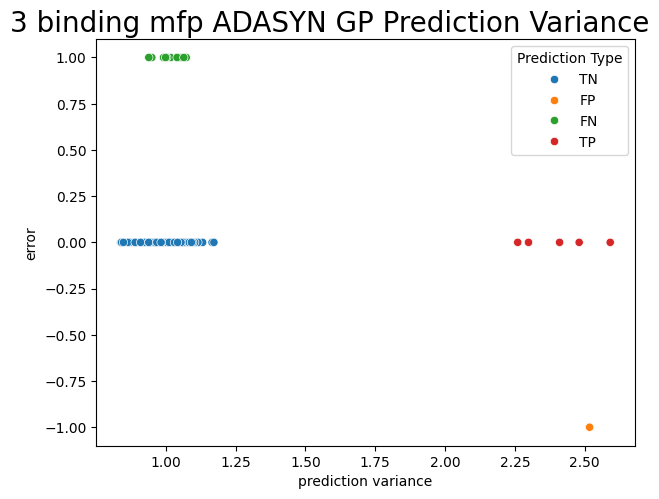

NEK5 binding


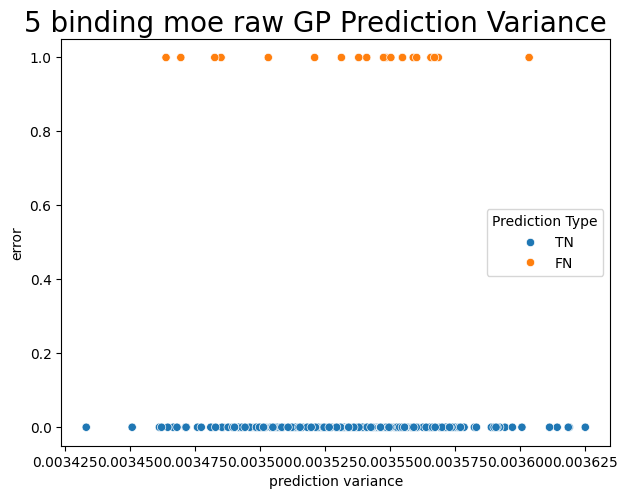

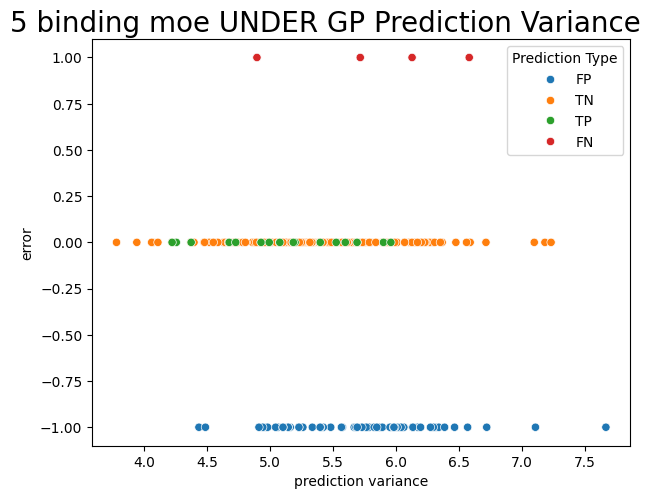

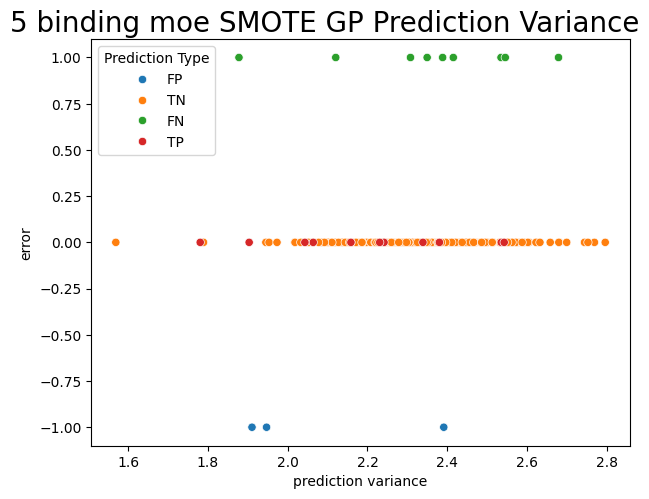

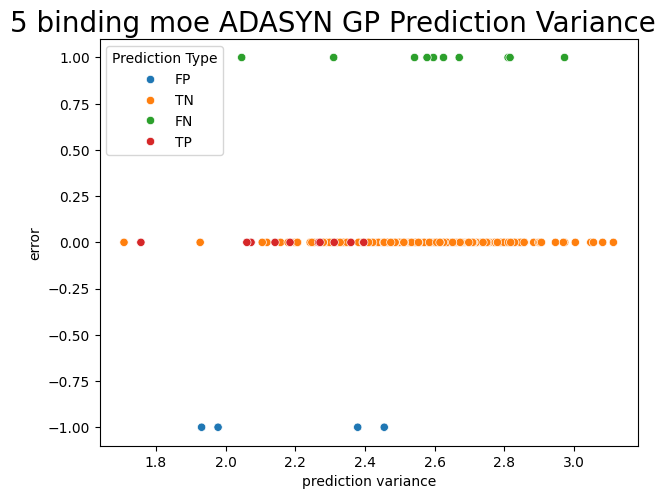

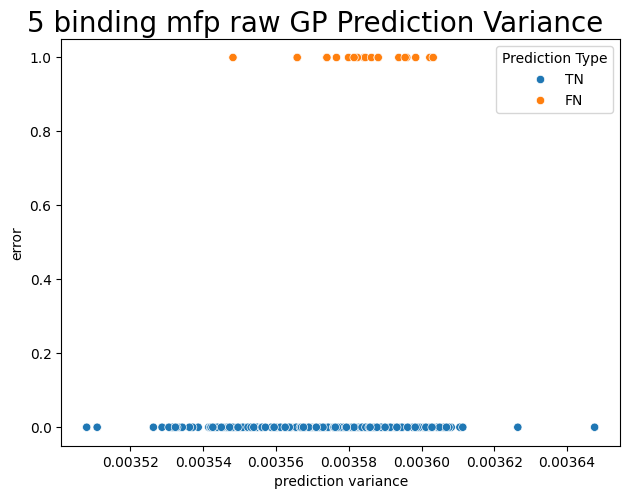

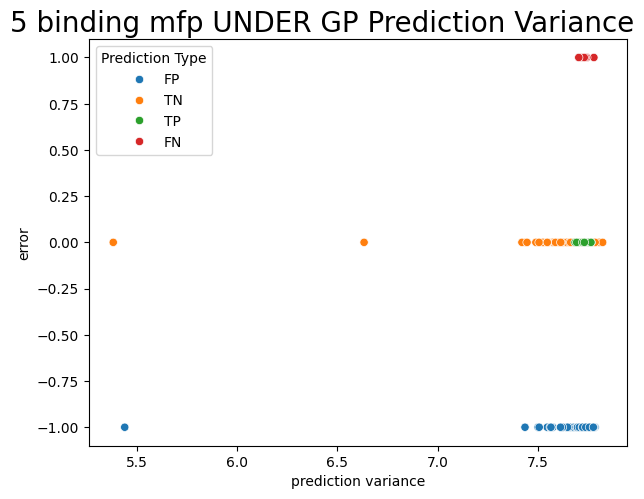

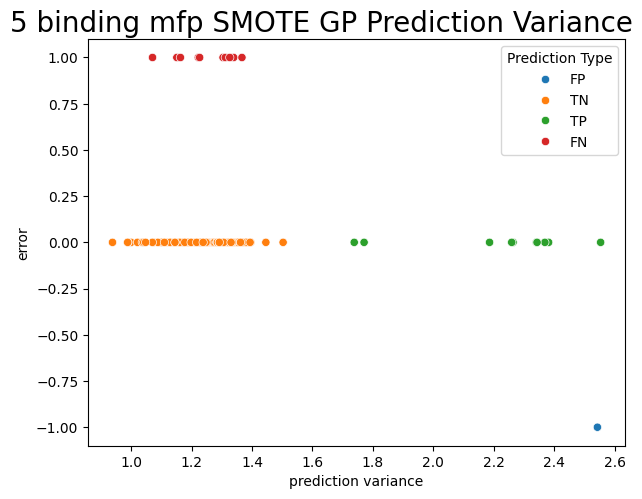

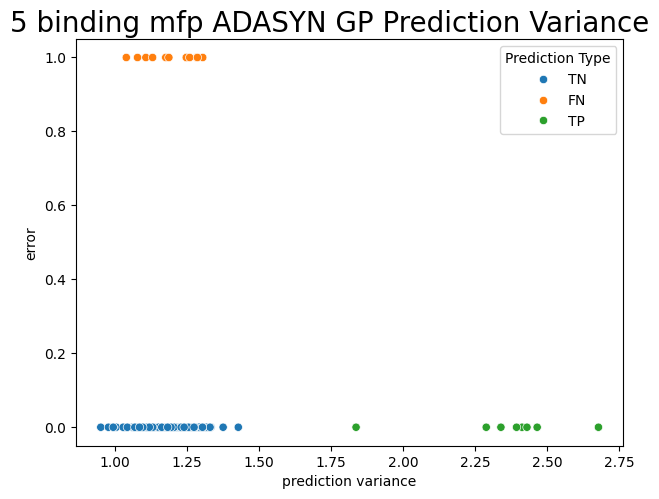

NEK9 binding


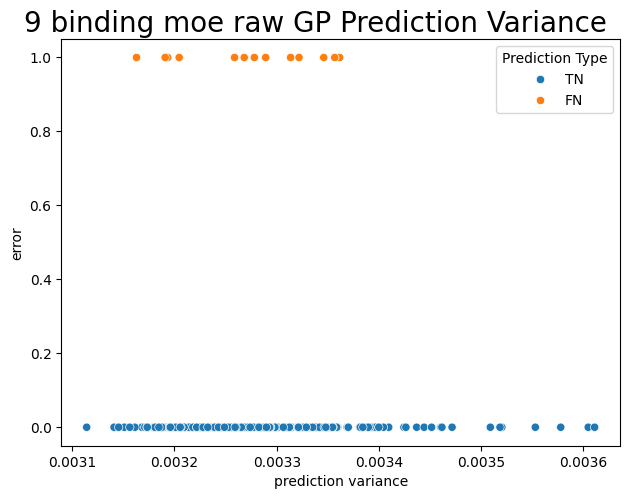

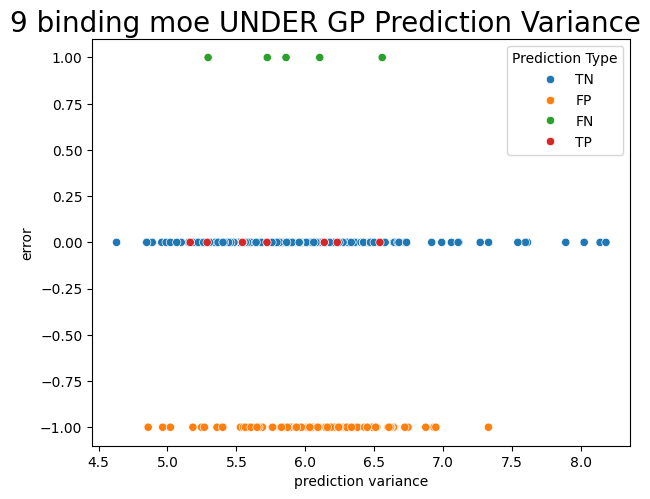

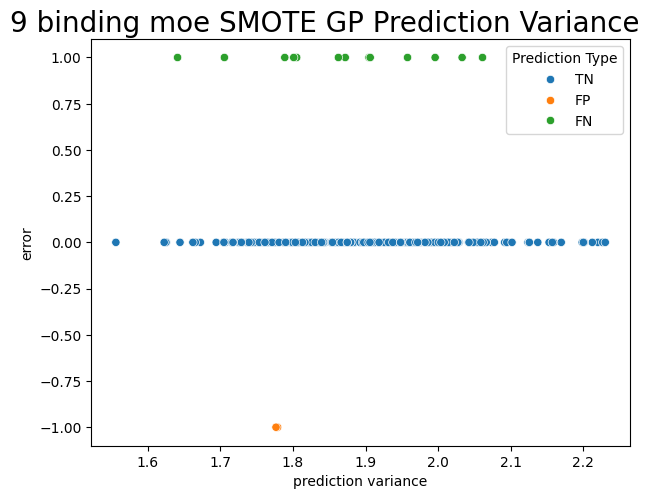

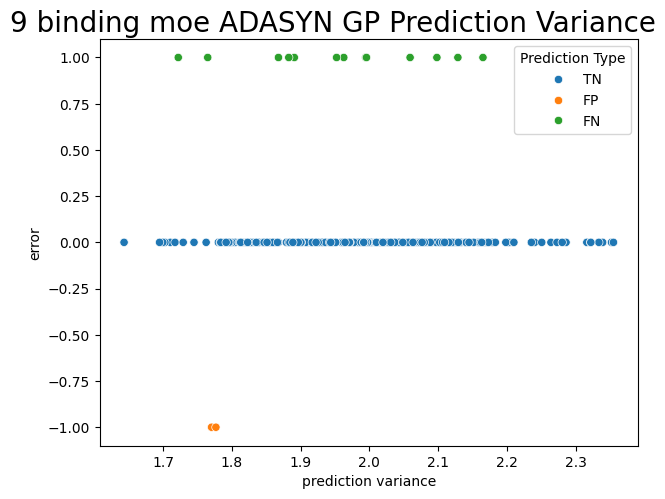

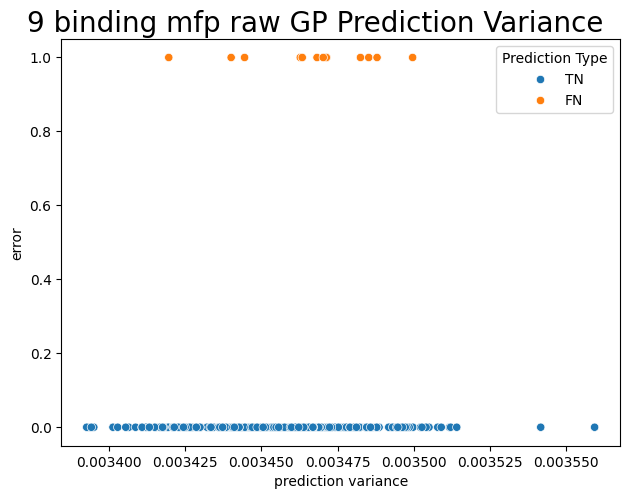

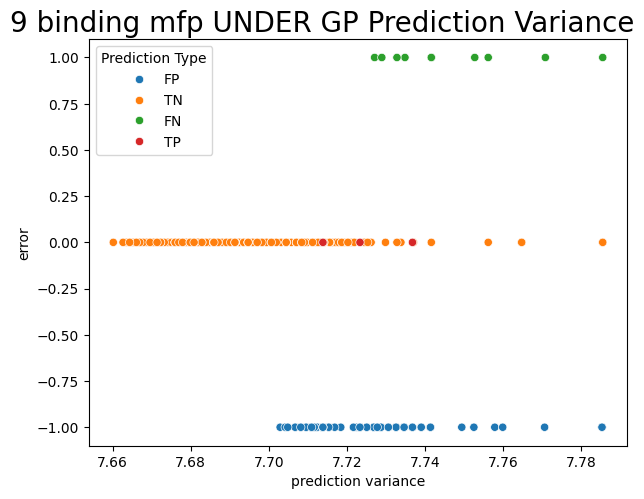

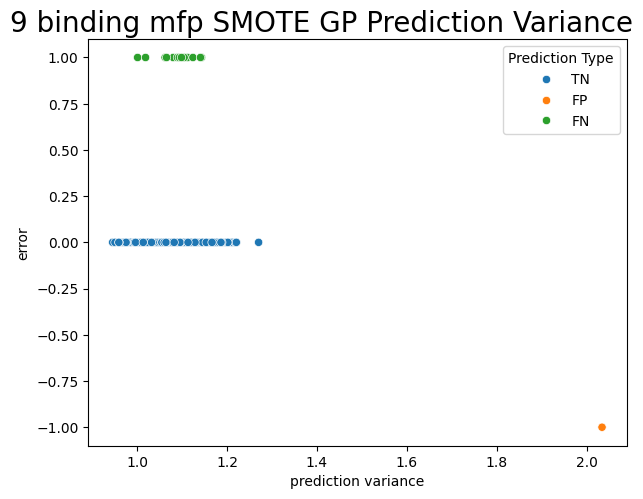

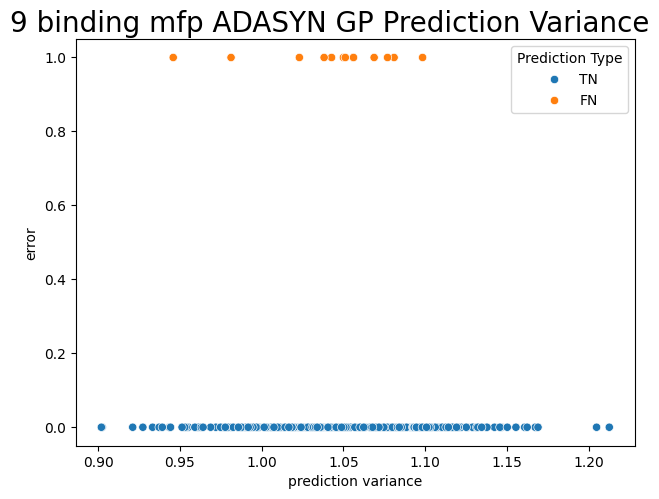

NEK9 inhibition


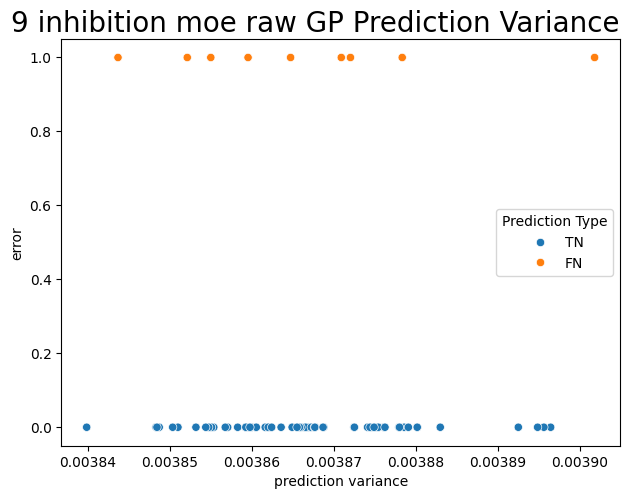

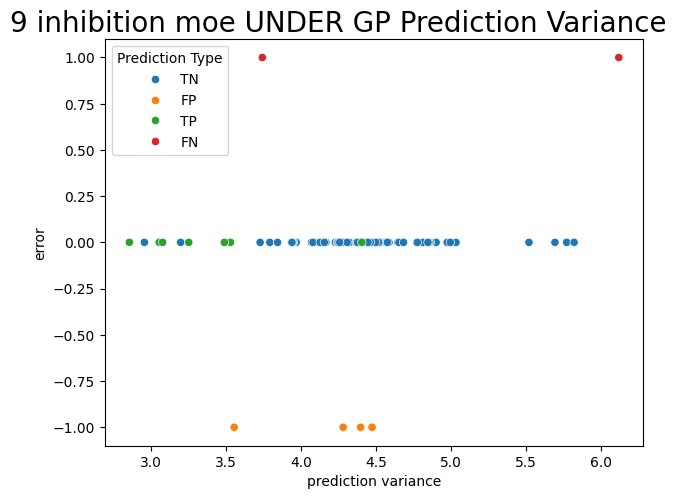

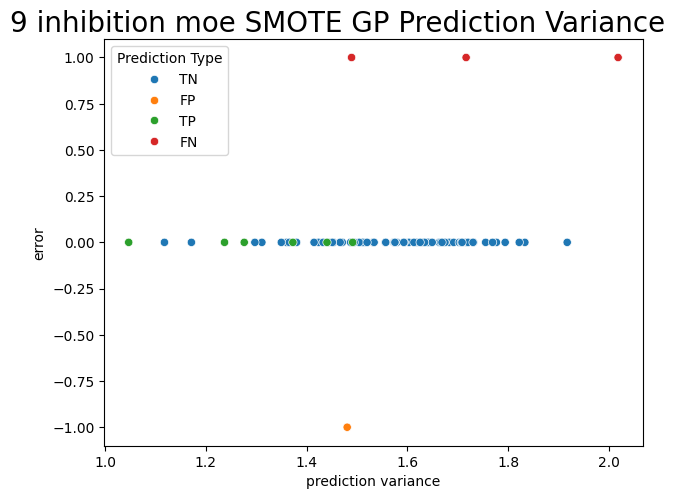

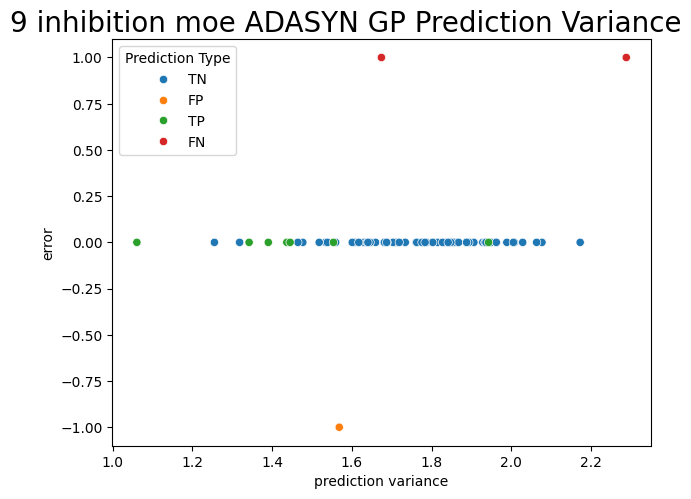

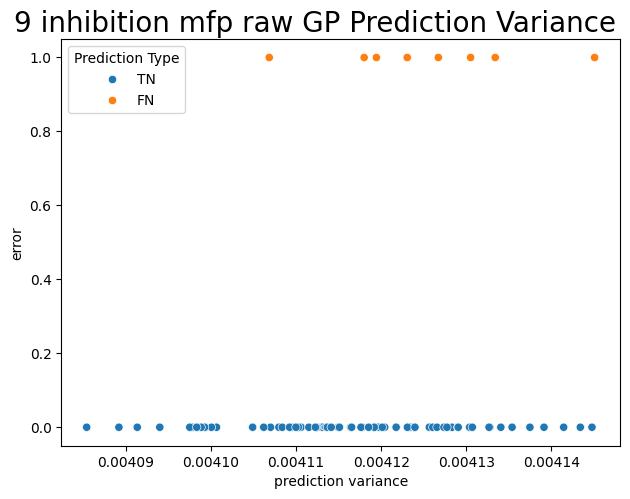

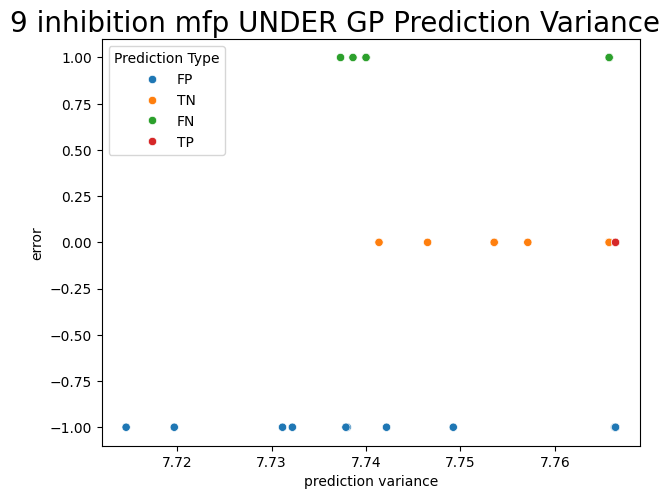

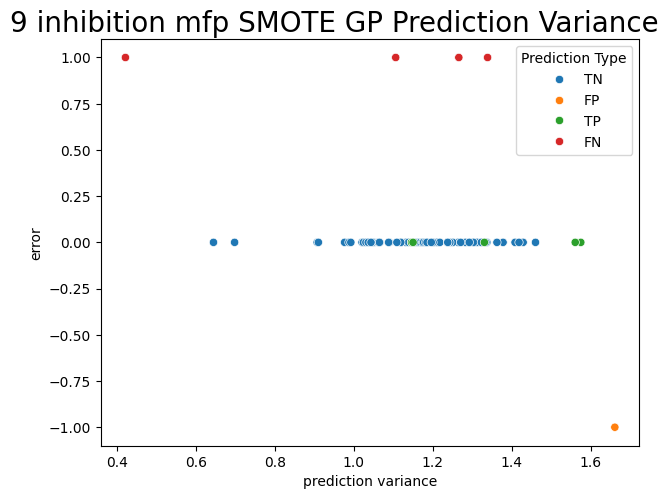

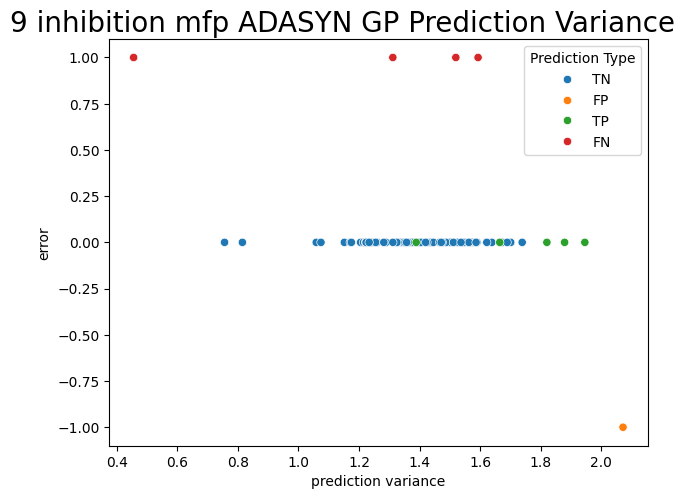

In [20]:
fig_path1 = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/figures/GP_plots/GP_UQ/individ/'
for nek in nek_list: 
    if nek in ['2', '9']: 
        bind_inhib =['binding', 'inhibition']
    else: 
        bind_inhib = ['binding']
    for bi in bind_inhib: 
        if bi == 'binding': 
            short = 'bind'
        else: 
            short = 'inhib'  
        this_nek = f'NEK{nek} {bi}'
        print(this_nek)
        for feat in feat_types: 
            for samp in samplings: 
                df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/NEK{nek}/{short}/'
                full_df = pd.read_csv(f'{df_path}NEK{nek}_{bi}_{feat}_{samp}_df.csv') 
                train_df = full_df[full_df['subset'] == 'train'].select_dtypes(include=numerics).drop(columns=['active'])
                test_df = full_df[full_df['subset'] == 'test'].select_dtypes(include=numerics).drop(columns=['active'])
                test_dist = calc_AD_kmean_dist(train_df, test_df, k)
                train_dist = calc_AD_kmean_dist(train_df, train_df, k)
                gp_results = pd.read_csv(f'{gp_path}NEK{nek}_{bi}_{feat}_{samp}_test_GP_matern.csv')
                gp_results['y'] = gp_results['y'].astype('Int64')

                df =pd.DataFrame({'actual': gp_results['y'].to_numpy(), 'prediction': gp_results['y_pred'].to_numpy(), 'prediction_type': gp_results['prediction_type'].to_numpy(),
                                  'var0': gp_results['var_pred_class0'].to_numpy(), 'var1': gp_results['var_pred_class1'].to_numpy(), 'ADdist': test_dist, 'feat_type': feat, 'strategy': samp})
                if samp == 'scaled': 
                    df = df.replace('scaled', 'raw')
                    samp = 'raw' 
                # figure_name = f'GPvar_AD_dist_scatter_class0or1_actual_NEK{nek}_{bi}_{feat}_{samp}'
                title = f'{nek} {bi} {feat} {samp} GP Prediction Variance'
                err_vs_var(df, title) 
                samp = 'scaled' 
